# PyDMD

## Tutorial 5: Forward-Backward Dynamic Mode Decomposition on numerical solutions

In this tutorial we will show the application of the forward-backward dynamic mode decomposition (see [Dawson et al.](https://arxiv.org/abs/1507.02264)) applied to the numerical solutions of a fluid dynamics problem. We run a simple simulation with the software [OpenFOAM](https://www.openfoam.com), taking one of the several tutorials provided: in this case, we simulate the flow of an incompressible turbulent fluid around some buildings by solving the Reynolds-averaged Navier Stokes equations using the *k-$\epsilon$* model. We will not discuss the simulation details, since the main purpose of this tutorial is to show a **PyDMD** usecase with numerical data, you can find all the information at this [link](https://github.com/OpenFOAM/OpenFOAM-5.x/tree/master/tutorials/incompressible/simpleFoam/windAroundBuildings).

First of all we import the FbDMD and the DMD classes from the pydmd package, we set matplotlib for the notebook, we import numpy and we import Ipython widgets (for some magic trick).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from pydmd import FbDMD
from pydmd import DMD

from ipywidgets import interact_manual, interact, interactive, FloatSlider

Now, we import the $x$ component of the flow velocity at the ground. In order to visualize the dataset, we load also the points coordinates.

In [2]:
snapshots = [
    np.genfromtxt('data/velocity0.{}.csv'.format(i), delimiter=',', skip_header=1)[:, 0]
    for i in range(20, 40)
]

pts = np.genfromtxt('data/velocity0.20.csv', delimiter=',', skip_header=1)[:, -3:-1]

We show some snapshots: since the original system was discretized using an unstructured grid, the visualization is not easy. We use a simple scatter plot in order to have an idea of what we are trying to analyze.

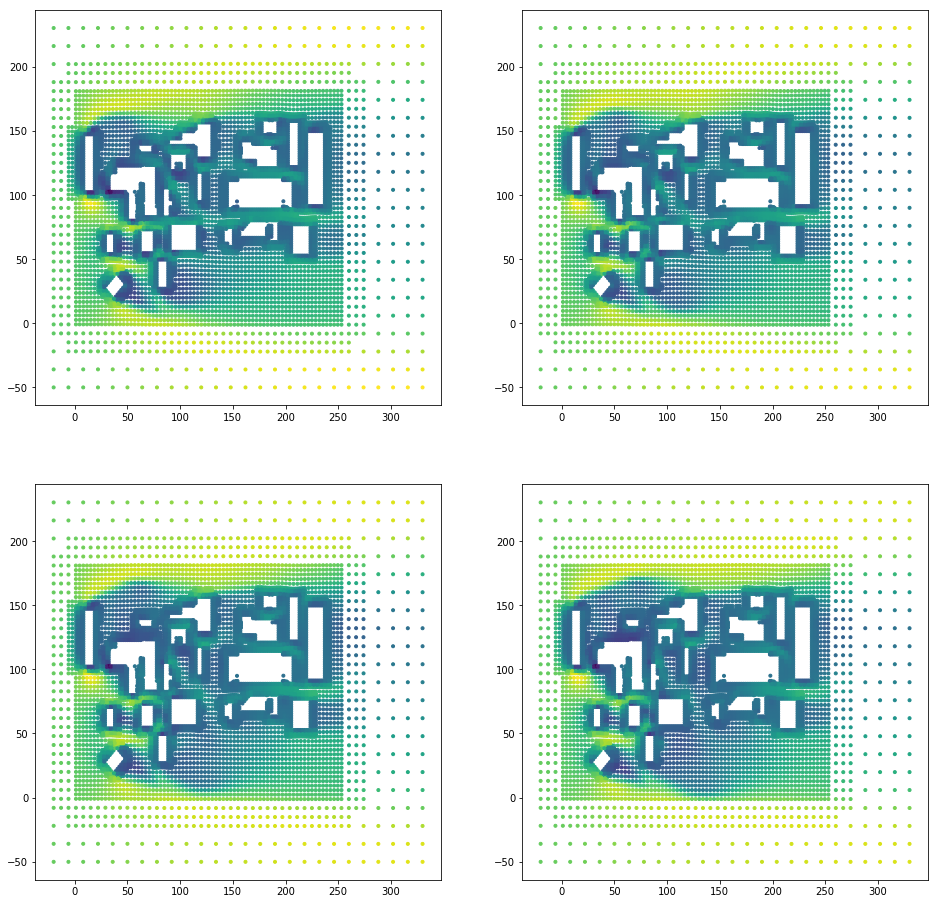

In [3]:
plt.figure(figsize=(16, 16))
for i, snapshot in enumerate(snapshots[::5], start=1):
    plt.subplot(2, 2, i)
    plt.scatter(pts[:, 0], pts[:, 1], c=snapshot, marker='.')
plt.show()

Alright, now we can decompose the snapshots matrix: we instantiate the new object then fit the snapshots. We remind that the argument of the `fit` method can be a 2D numpy.ndarray or a simple iterable object, like a list or a tuple.

In [4]:
fbdmd = FbDMD(exact=True)
fbdmd.fit(snapshots)
fbdmd.reconstructed_data.shape

(7219, 20)

The forward-backward version reduces the error by computing the low-rank linear operator as the square root of the product between the operator for the forward evolution and the operator for the backward evolution. The `FbDMD` class has the same attributes and methods of the `DMD` class. Try to compare this version with the original one, by checking the stability of the dynamics.

[DMD  ] Total distance between eigenvalues and unit circle: 1.58030503851
[FbDMD] Total distance between eigenvalues and unit circle: 0.8977200007


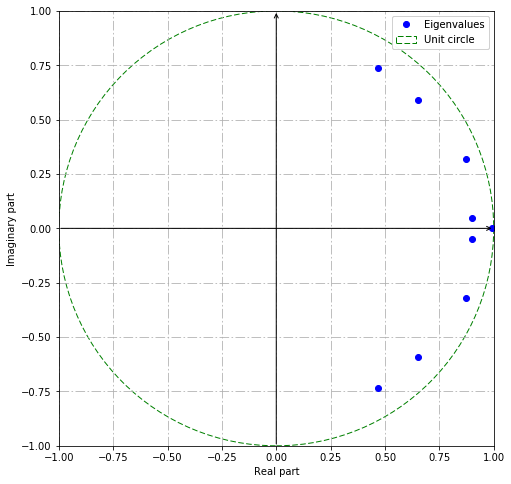

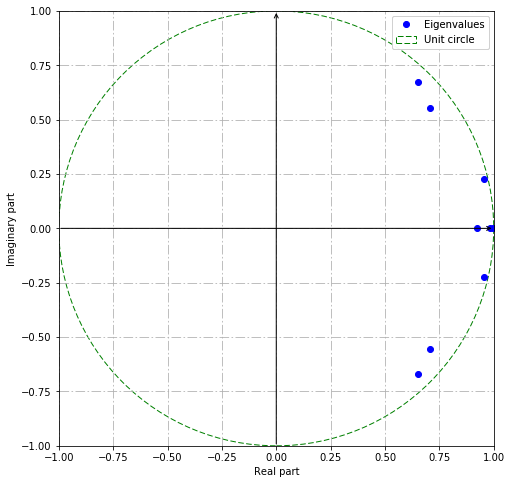

In [5]:
dmd = DMD(exact=True)
dmd.fit(snapshots)

print('[DMD  ] Total distance between eigenvalues and unit circle: {}'.format(
    np.sum(np.abs(dmd.eigs.real**2 + dmd.eigs.imag**2 - 1))
))
print('[FbDMD] Total distance between eigenvalues and unit circle: {}'.format(
    np.sum(np.abs(fbdmd.eigs.real**2 + fbdmd.eigs.imag**2 - 1))
))

dmd.plot_eigs()
fbdmd.plot_eigs()

The eigenvalues from the forward-backward dynamic mode decomposition are closer to unit circle, compared to the ones from the standard DMD! Dealing with numerical solutions, where a small noise is often present, this algorithm can be the right way.

Now let's manipulate the temporal window in order to have a small future prediction of the system. Moreover, we halve the delta-time in order to have more reconstructed snapshots.

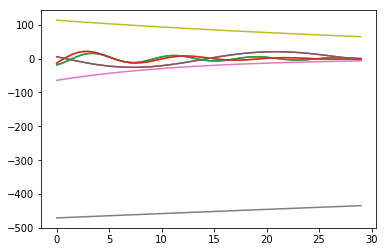

In [6]:
fbdmd.dmd_time['dt'] *= .5
fbdmd.dmd_time['tend'] += 10

plt.plot(fbdmd.dmd_timesteps, fbdmd.dynamics.T.real)
plt.show()

To conclude the tutorial, the coolest part! We create a simple function that plots the proper reconstructed snapshot given the right time. Then we use the Ipython widgets to interactively show the states of the system, allowing the user to understand the evolution just touching a slider. If you have an old version of the ipython widgets it is possible that this line: output.layout.height = '500px', produces some trouble. Just comment it in that case.

In [7]:
def plot_state(time):
    i = int((time - fbdmd.dmd_time['t0']) / fbdmd.dmd_time['dt'])
    plt.figure(figsize=(8,8))
    plt.scatter(pts[:, 0], pts[:, 1], c=fbdmd.reconstructed_data[:, i].real, marker='.')
    plt.show()
    
interactive_plot = interactive(
    plot_state, 
    time=FloatSlider(
        min=fbdmd.dmd_time['t0'],
        max=fbdmd.dmd_time['tend'],
        step=fbdmd.dmd_time['dt'],
        value=0,
        continuous_update=False
    )
)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

AttributeError: 'FloatSlider' object has no attribute 'layout'

We successfully use the **PyDMD** package to data that comes from a real application, using the forward-backward algorithm in order to delete the numerical noise.